<a href="https://colab.research.google.com/github/electricshadok/notebooks/blob/main/backprop_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understand Backpropagation (JAX implementation)

This section focuses on implementing **backpropagation from scratch** using JAX.
We will construct a **two-layer neural network** to demonstrate the forward pass,
backward pass (gradient calculation), and parameter updates using gradient descent.

## Packages

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

## Utilities

The **sigmoid activation function** is used to map input values to the range $(0, 1)$, making it useful for probability-based outputs or as an activation function.

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

Where:
- $x$ is the input value (scalar or tensor).
- $\sigma(x)$ is the sigmoid output.


The **Mean Squared Error (MSE)** measures the average squared difference between predicted and actual values. It is commonly used in regression problems.

$$\text{MSE}(y_{\text{true}}, y_{\text{pred}}) = \frac{1}{n} \sum_{i=1}^{n} \left( y_{\text{true},i} - y_{\text{pred},i} \right)^2$$

Where:
- $y_{\text{true}}$: Ground truth target values.
- $y_{\text{pred}}$: Predicted values.
- $n$: Number of samples.

In [2]:
# Sigmoid Activation
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

# Loss Function (Mean Squared Error)
def mse_loss(y_true, y_pred):
    return jnp.mean((y_true - y_pred) ** 2)

## Linear layer (Forward and Backward pass)



The Linear layer is a fundamental building block in neural networks. It performs a linear transformation on the input, parameterized by weights ($W$) and biases ($b$).

**Forward pass**

The forward pass of the **Linear** layer computes:

$$z=XW+b$$

Where:

- $X$ is the input matrix $(m, \text{in_features})$, where $m$ is the batch size.
- $W$ is the weight matrix of shape $(\text{in_features}, \text{out_features})$
- $b$ is the bias vector of shape $(\text{out_features})$
- $z$ is the output (pre-activation) matrix of shape $(m, \text{out_features})$


**Backward pass : Gradient for $W$**

The backward pass computes the gradients of the loss $L$ with respect to the weights $W$.

$$\frac{\partial L }{\partial W} = X^\top \delta$$

Where:

- $X^\top$  is the transpose of the input matrix X
- $\delta = \frac{\partial L}{\partial z}$ is the gradient of the loss with respect to the output $z$, with shape $(m, \text{out_features})$
- $\frac{\partial L}{\partial W} $ has shape $(\text{in_features}, \text{out_features})$.

**Backward pass : Gradient for $b$**

The gradient of the loss $L$ with respect to the biases $b$ is:

$$\frac{\partial L}{\partial b} = \sum_{i=1}^m \delta_i$$


Where:

- $\delta_i$ is the $i$-th row of $\delta$.
- Summing over all rows gives $\frac{\partial L}{\partial b} $ has shape $(\text{out_features})$.


**Optimizer pass**

Update the parameters ($W$ and $b$) using **gradient descent**:

$$W \leftarrow W - \alpha \frac{\partial L}{\partial W}$$

$$b \leftarrow b - \alpha \frac{\partial L}{\partial b}$$

Where:

- $\alpha$ is the learning rate.
- $\frac{\partial L}{\partial W}$ and $\frac{\partial L}{\partial b}$ are computed in the backward pass.



In [3]:
class Linear:
    def __init__(self, in_features, out_features, key):
        """
        Initialize the linear layer with weights, biases, and placeholder gradients.

            Args:
                in_features (int): Number of input features.
                out_features (int): Number of output features.
                key (jax.random.PRNGKey): Random key for initializing weights.
        """
        self.W = jax.random.normal(key, (in_features, out_features)) * 0.01
        self.b = jnp.zeros((out_features,))

        # Initialize gradients with the same shape as weights and biases
        self.gradW = jnp.zeros_like(self.W)  # Gradient for weights
        self.gradb = jnp.zeros_like(self.b)  # Gradient for biases

    def forward(self, x):
        """
        Perform the forward pass: compute z = XW + b.
        """
        self.input = x  # Cache input for gradient computation
        return jnp.dot(x, self.W) + self.b

    def backward(self, grad_output):
        """
        Compute gradients for this layer.
        Args:
            grad_output: Gradient of the loss w.r.t. the output of this layer.
        return: Gradient of the loss w.r.t. the input to this layer.
        """
        # Gradient w.r.t. weights and biases
        self.gradW = jnp.dot(self.input.T, grad_output)
        self.gradb = jnp.sum(grad_output, axis=0)

        # Gradient w.r.t. inputs to this layer
        grad_input = jnp.dot(grad_output, self.W.T)
        return grad_input

    def update(self, learning_rate):
        """
        Update weights and biases using stored gradients.
        """
        self.W -= learning_rate * self.gradW
        self.b -= learning_rate * self.gradb

## Network (Two fully connected layers)

Build a simple neural network by chaining two Linear layers.

In [4]:
class Network:
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        """
        A simple neural network consisting of two fully connected (linear) layers.

        Args:
            input_dim (int): Number of input features for the network.
            hidden_dim (int): Number of neurons in the hidden layer.
            output_dim (int): Number of output features for the network.
        """
        key = jax.random.key(seed=10)
        key1, key2 = jax.random.split(key)
        layer1 = Linear(input_dim, hidden_dim, key1)
        layer2 = Linear(hidden_dim, output_dim, key2)
        self.layers = [layer1, layer2]

    def forward(self, x):
        """
        Perform the forward pass through the network.
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, x, y):
        """
        Perform the backward pass to compute gradients for all layers.
        """
        y_pred = self.forward(x)
        grad_output = (y_pred - y) / y.shape[0]  # Gradient of MSE Loss
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)

    def update(self, learning_rate):
        """
        Update weights and biases of all layers using gradient descent.
        """
        for layer in self.layers:
            layer.update(learning_rate)

    def compute_loss(self, x, y):
        """
        Compute the Mean Squared Error (MSE) loss.
        """
        y_pred = self.forward(x)
        return jnp.mean((y - y_pred) ** 2)  # Mean Squared Error Loss

## Simple Regression Task

In this regression task, we generate data based on a simple linear equation:

$$2x_1 + 3x_2 - 1 $$

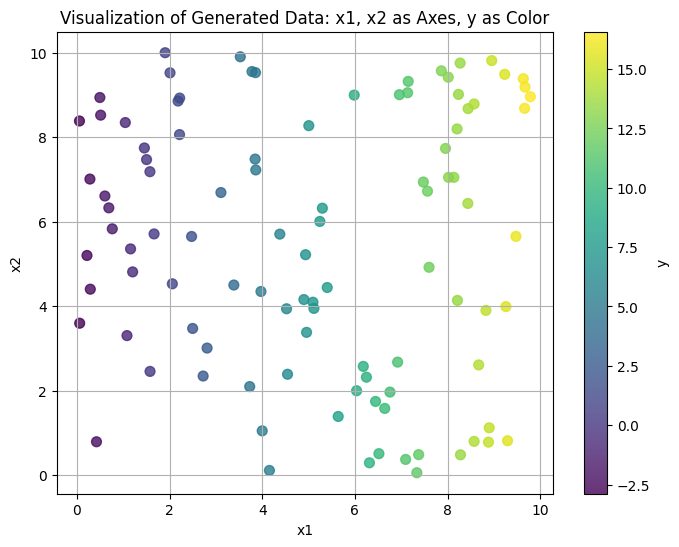

In [5]:
# Define the simple function: y = 2x1 + 3x2 - 1
def generate_data(num_samples=100):
    x = jax.random.uniform(jax.random.PRNGKey(0), (num_samples, 2)) * 10  # Random x1, x2 values
    x_1, x_2 = x[:, 0:1], x[:, 1:2]
    y = 2 * x[:, 0:1] + 3 *  - 1
    return x, y

# Create datasets
TRAIN_X, TRAIN_Y = generate_data(100)
TEST_X, TEST_Y = generate_data(10)

# Visualize the data in 2D with x1 and x2 as axes and y as color
plt.figure(figsize=(8, 6))
plt.scatter(TRAIN_X[:, 0], TRAIN_X[:, 1], c=TRAIN_Y, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(label="y")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Visualization of Generated Data: x1, x2 as Axes, y as Color")
plt.grid(True)
plt.show()

Train the network !!

In [6]:
LEARNING_RATE = 0.001
EPOCHS = 500

network = Network(input_dim = 2,hidden_dim = 4, output_dim = 1)

for epoch in range(EPOCHS):
    network.backward(TRAIN_X, TRAIN_Y)  # Backward pass
    network.update(LEARNING_RATE)  # Update weights

    if epoch % 100 == 0:
        loss = network.compute_loss(TRAIN_X, TRAIN_Y)
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 88.0111
Epoch 100, Loss: 13.4293
Epoch 200, Loss: 2.1148
Epoch 300, Loss: 1.5589
Epoch 400, Loss: 1.4449


Make predictions using the trained network.

In [7]:
# Test the Network
y_pred = network.forward(TEST_X)
errors = TEST_Y.flatten() - y_pred.flatten()

print("\nTest Predictions vs Actual Values:")
for i in range(10):
    print(f"Input: {TEST_X[i]}, Predicted: {y_pred[i][0]:.2f}, Actual: {TEST_Y[i][0]:.2f}")


Test Predictions vs Actual Values:
Input: [8.541766  1.6620052], Predicted: 14.64, Actual: 14.08
Input: [2.7605474 4.8728156], Predicted: 3.69, Actual: 2.52
Input: [9.920441  0.3015983], Predicted: 17.40, Actual: 16.84
Input: [2.162943  3.7687123], Predicted: 2.94, Actual: 1.33
Input: [6.3070035 9.614448 ], Predicted: 8.64, Actual: 9.61
Input: [1.5203023 9.20903  ], Predicted: 0.39, Actual: 0.04
Input: [3.0555236 2.9931295], Predicted: 4.70, Actual: 3.11
Input: [6.925707 8.542826], Predicted: 10.01, Actual: 10.85
Input: [4.651738  7.8693066], Predicted: 6.21, Actual: 6.30
Input: [9.960528  2.8018546], Predicted: 16.82, Actual: 16.92
